# M6 Time Domain Metric Analysis

The M6 metric examines how often a survey region is revisited.  All science cases, by definition, require at least one visit to all HEALpixels in their desired survey region, while some indicate that multiple visits would be needed. The M6 metric calculates the area of a desired survey region to actually receive the requested number of visits in a survey strategy and compares this with the requested cadence. The result is expressed as a percentage of the requested visits, M6_%sky_area_nvisits.

Unlike the other metrics, this calculation is made separately for each region within a (science case, filter) or (survey design, filter) combination. This is because some cases request different cadence strategies for different sub-regions.

As a result, the metric output is quite complicated, and its best evaluated in smaller segments.

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
all_survey_regions = regions.load_regions_from_file(sim_config, path.join(sim_config['root_dir'], 'region_data', 'rgps_survey_regions.json'))

In [4]:
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

## Configuration of time domain proposals 

In the JSON format files in config/ time domain parameters are included for each requested observing region independently, to enable different regions to receive different observing strategies.  The parameters are:

In [151]:
nvisits= 8 # floating point - nvisits < 1.0 indicates that multiple filters will be used within a single visit
duration= 3.5  # [days] Interval between the first and last observation of the current region
visit_interval= '[0.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]' # [hours, can be null] Intervals between successive visits

## M6 Sky area revisits - Time domain metric 

There are many comparisions which can be made for this metric (in terms of science regions, survey regions, filters and survey elements), since each region can have a different observing strategy in terms of number of visits, filter choice etc.  This makes it quite complicated to compare the metric in a uniform way for all science cases simultaneously. 

Given the RGPS survey as designed, only the time_domain fields provide meaningful time domain coverage, so we focus here on the results of evaluating the M6 metric for RGPS time domain fields, comparing them to the regions requested in community proposals categorize as time domain.  

Note: In this metric table, the metric is calculated for each survey region and science region and filter.  However, in some cases 
there may be no survey observations of any region in the given filter, so no specific regions are specified and the name of the survey - i.e. "time_domain" as a whole is listed for the region.  

### Time domain region overlap

Cumulatively, the community requested time domain observations of a very large area of sky, far more than the RGPS' time allocation could possibly support.  So the first question to address is which regions - and therefore which science cases - were included in the design.  This metric considers observations in any filter, on the grounds that several authors indicated that observations in any of a set of filters would be beneficial.  

This information is in the first of the two tables of output produced by M6. 

In [134]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_overlap_results.txt')

m6_results1 = Table.read(m6_results_file, format='ascii')
m6_results1

Survey_region,Science_region,Common_area,M6_%TD_Region
str31,str27,float64,float64
time_domain_TDS_Baades_Windows,Paladini2_Paladini2,0.0,0.0
time_domain_TDS_Galactic_Center,Paladini2_Paladini2,0.0,0.0
time_domain_TDS_NGC6334_6357,Paladini2_Paladini2,0.0,0.0
time_domain_TDS_Carina,Paladini2_Paladini2,0.0,0.0
time_domain_TDS_W43,Paladini2_Paladini2,0.0,0.0
time_domain_TDS_Serpens_W40,Paladini2_Paladini2,18.464460194645667,48.88888888888888
time_domain_TDS_Baades_Windows,Benecchi_Benecchi1,0.0,0.0
time_domain_TDS_Galactic_Center,Benecchi_Benecchi1,0.0,0.0
time_domain_TDS_NGC6334_6357,Benecchi_Benecchi1,0.0,0.0


Let's tabulate which regions were included and which not.  Note that there is a special case made for catalog which include a large number of target areas.  Including these regions separately doesn't make much sense and overwhelms the table, so the metric sums the region of overlap for all survey regions over all targets in the catalog before calculating the metric. 

In [135]:
# Build a list of the regions from all science cases 
science_regions = list(set(m6_results1['Science_region']))
science_regions.sort()

# Build a list of the survey time domain regions
survey_regions = list(set(m6_results1['Survey_region']))
survey_regions.sort()

In [136]:
# For each science region, check to see which if any survey region overlaps with it, tabulating the results 
data = []
for rscience in science_regions:

    # Filter for the results for this region
    idx = np.where(m6_results1['Science_region'] == rscience)[0]
    metric_filter = m6_results1[idx]

    # Identify which region overlaps if any 
    jdx = np.where(metric_filter['Common_area'] > 0.0)[0]

    # Desired region not covered by survey fields
    if len(jdx) == 0: 
        data.append([rscience, 'Any', 0.0, 0.0])

    # Desired region covered by one or more fields 
    else:
        for j in jdx: 
            data.append(
                [
                    rscience, 
                    metric_filter[j]['Survey_region'].replace('time_domain_',''), 
                    metric_filter[j]['Common_area'], 
                    metric_filter[j]['M6_%TD_Region']
                ]
            )
    
data = np.array(data)

overlap_results = Table([
        Column(name='Science_region', data=data[:, 0], dtype='S40'),
        Column(name='Survey_region', data=data[:, 1], dtype='S50'),
        Column(name='Common_area', data=data[:, 2], dtype='f8'),
        Column(name='M6_%TD_Region', data=data[:, 3], dtype='f8'),
    ])

overlap_results.pprint_all()

       Science_region          Survey_region       Common_area        M6_%TD_Region   
--------------------------- ------------------- ------------------ -------------------
             Bahramian_XRB1  TDS_Baades_Windows  6.714349161689334 0.14847809948032664
             Bahramian_XRB1 TDS_Galactic_Center  7.553642806900501 0.16703786191536749
             Bahramian_XRB1    TDS_NGC6334_6357  7.553642806900501 0.16703786191536749
             Bahramian_XRB1          TDS_Carina  7.553642806900501 0.16703786191536749
             Bahramian_XRB1             TDS_W43  6.714349161689334 0.14847809948032664
             Bahramian_XRB1     TDS_Serpens_W40 18.464460194645667  0.4083147735708982
             Bahramian_XRB2  TDS_Baades_Windows 1.6785872904223336 0.09871668311944717
             Bahramian_XRB2 TDS_Galactic_Center  7.553642806900501  0.4442250740375123
             Bahramian_XRB2    TDS_NGC6334_6357  7.553642806900501  0.4442250740375123
             Bahramian_XRB2          TDS_Ca

The second stage of the M6 metric evaluates how suitable the time cadence of observing strategy is for each science case. 

In [137]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_results.txt')

m6_results2 = Table.read(m6_results_file, format='ascii')
m6_results2

Survey_strategy,Survey_region,Science_case,Science_region,Optic,M6_%nvisits,M6_%duration
str11,str31,str9,str27,str4,float64,float64
time_domain,time_domain_TDS_Baades_Windows,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_NGC6334_6357,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Carina,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Serpens_W40,Paladini2,Paladini2_Paladini2,F213,100.0,85.71428571428571
time_domain,time_domain,Benecchi,Benecchi_Benecchi1,F146,0.0,0.0
time_domain,time_domain_TDS_Baades_Windows,Kupfer,Kupfer_NGC6528,F062,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center,Kupfer,Kupfer_NGC6528,F062,0.0,0.0
time_domain,time_domain_TDS_NGC6334_6357,Kupfer,Kupfer_NGC6528,F062,0.0,0.0


We'd like to know which of the requested regions receives the desired coverage.  The discrete nature of the time domain fields means that it only makes sense to consider the survey fields that overlap the requested region.  However, several science cases asked for a huge catalog of fields, while others asked for all filters and a large set of fields.  Plotting all of these on a single plot is complicated, so opting for more specific graphics here.  

In [148]:
# For each combination of science and survey region with known overlap, extract the metric data for each filter 
# requested by the science case.  
# Plot M6_%nvisits vs M6_%duration for each science/survey region overlap
data = []
for row in overlap_results:
    
    # Select metric table entries for all filters requested for the row's science region
    rscience = row['Science_region']
    rsurvey = row['Survey_region']
    idx1 = np.where(m6_results2['Science_region'] == rscience)[0]
    idx2 = np.where(m6_results2['Survey_region'] == 'time_domain_' + rsurvey)[0]
    idx = list(set(idx1).intersection(set(idx2)))
    
    for i in idx:
        data.append([rscience, rsurvey, m6_results2[i]['Optic'], m6_results2[i]['M6_%nvisits'], m6_results2[i]['M6_%duration']])

data = np.array(data)

metric_results = Table([
        Column(name='Science_region', data=data[:, 0], dtype='S40'),
        Column(name='Survey_region', data=data[:, 1], dtype='S50'),
        Column(name='Optic', data=data[:,2], dtype='S30'),
        Column(name='M6_%nvisits', data=data[:, 3], dtype='f8'),
        Column(name='M6_%duration', data=data[:, 4], dtype='f8'),
    ])

metric_results

Science_region,Survey_region,Optic,M6_%nvisits,M6_%duration
bytes40,bytes50,bytes30,float64,float64
Bahramian_XRB1,TDS_Baades_Windows,F213,47.77777777777778,0.4444444444444444
Bahramian_XRB1,TDS_Baades_Windows,F129,0.2222222222222222,0.4444444444444444
Bahramian_XRB1,TDS_Baades_Windows,F087,0.2222222222222222,0.4444444444444444
Bahramian_XRB1,TDS_Galactic_Center,F213,56.666666666666664,3.3333333333333335
Bahramian_XRB1,TDS_Galactic_Center,F087,0.2777777777777778,0.4444444444444444
Bahramian_XRB1,TDS_Galactic_Center,F129,0.2777777777777778,0.4444444444444444
Bahramian_XRB1,TDS_NGC6334_6357,F087,0.2222222222222222,0.4444444444444444
Bahramian_XRB1,TDS_NGC6334_6357,F213,47.77777777777778,0.4444444444444444
Bahramian_XRB1,TDS_NGC6334_6357,F129,0.2222222222222222,0.4444444444444444


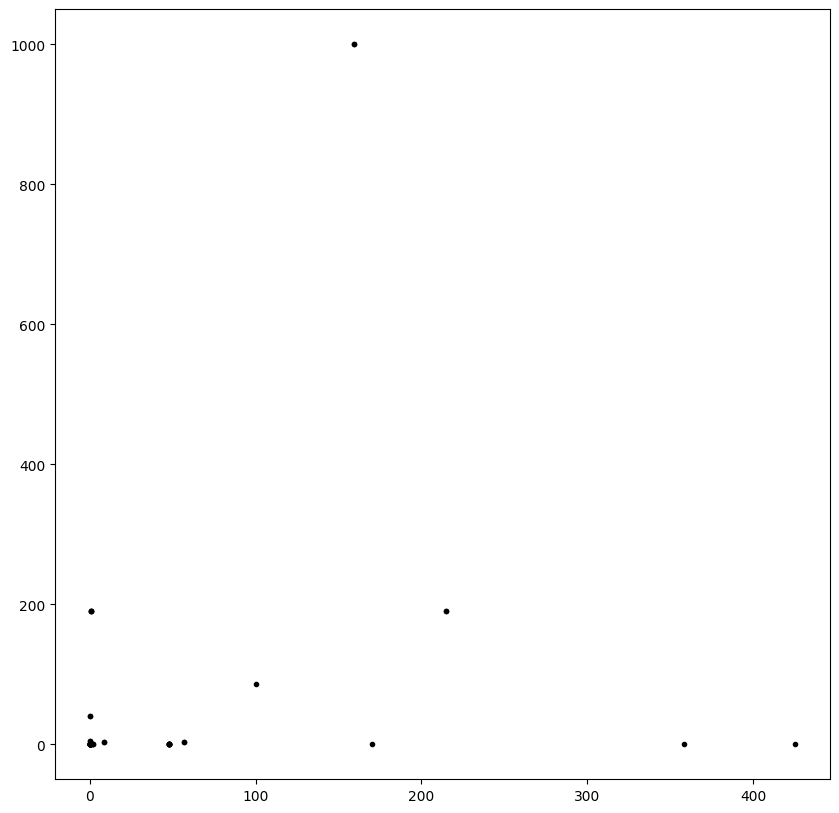

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

ax.plot(metric_results['M6_%nvisits'], metric_results['M6_%duration'], 'k.')